In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/DB/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [3]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [5]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [6]:
train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [7]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [8]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [10]:
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes.astype(np.float32)
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [11]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.Rotate(limit=80),
        A.Rotate(limit=35, p=0.9),
        A.RandomRotate90(p=0.25),
        A.RandomBrightnessContrast(p=0.85),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [12]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [13]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [14]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = "cpu"
print("device :", device)

device : cpu


In [17]:
# print(images[0])
print("hello")
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


 

hello


In [18]:
images[0]

tensor([[[0.4430, 0.3929, 0.3588,  ..., 0.3891, 0.3719, 0.3611],
         [0.4891, 0.4334, 0.3919,  ..., 0.3791, 0.3588, 0.3508],
         [0.5441, 0.4933, 0.4583,  ..., 0.3642, 0.3437, 0.3371],
         ...,
         [0.4878, 0.4848, 0.4704,  ..., 0.2689, 0.2743, 0.2741],
         [0.4603, 0.4873, 0.4563,  ..., 0.2578, 0.2674, 0.2728],
         [0.4219, 0.4715, 0.4263,  ..., 0.2519, 0.2610, 0.2639]],

        [[0.4623, 0.4060, 0.3713,  ..., 0.3729, 0.3557, 0.3449],
         [0.5094, 0.4530, 0.4122,  ..., 0.3629, 0.3425, 0.3346],
         [0.5651, 0.5235, 0.4972,  ..., 0.3479, 0.3275, 0.3209],
         ...,
         [0.4774, 0.4858, 0.4876,  ..., 0.2648, 0.2703, 0.2701],
         [0.4546, 0.4924, 0.4709,  ..., 0.2538, 0.2633, 0.2688],
         [0.4311, 0.4827, 0.4386,  ..., 0.2478, 0.2570, 0.2599]],

        [[0.4745, 0.4253, 0.3913,  ..., 0.3607, 0.3458, 0.3408],
         [0.5216, 0.4659, 0.4244,  ..., 0.3507, 0.3314, 0.3305],
         [0.5696, 0.5229, 0.4932,  ..., 0.3357, 0.3153, 0.

In [52]:
targets[0]

{'boxes': tensor([[676.3542, 556.1526, 723.5418, 590.0007],
         [168.6141, 343.9338, 275.4226, 402.7202],
         [279.2711, 288.8899, 353.6476, 420.6260],
         [682.3420, 593.8239, 778.1378, 688.2858],
         [ 50.7235, 632.9553, 159.1971, 736.7601],
         [446.1438, 395.8853, 550.1063, 494.5121],
         [ 29.5719, 335.9413,  97.8432, 379.5345],
         [503.4332, 479.1351, 605.8681, 550.2223],
         [329.3464, 452.1772, 390.7393, 522.9077],
         [761.4980, 493.1252, 800.0000, 578.8245],
         [ 60.0208, 677.1998, 171.7530, 793.6008],
         [ 22.8311, 388.0422,  63.3490, 428.5601],
         [122.9308, 716.7905, 222.3517, 793.5343],
         [371.0673, 721.1118, 465.9263, 800.0000],
         [607.8534, 453.1987, 709.8913, 537.8953],
         [455.5389, 641.6544, 514.3253, 748.4629],
         [128.6577, 552.3166, 230.4257, 624.0707],
         [340.6432, 248.8909, 438.8063, 311.0376],
         [149.0880, 267.2162, 244.5579, 337.3411],
         [ 60.4195,  8

In [19]:
boxes = targets[5]['boxes'].cpu().numpy().astype(np.int32)
sample = images[5].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


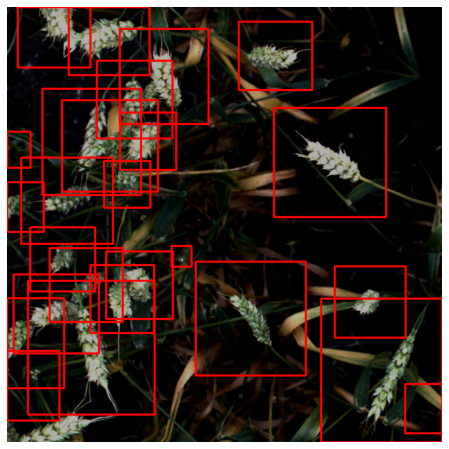

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [21]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
learning_rate = 0.0001
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=learning_rate)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 1

# Evaluation

- pascal_voc: min/max coordinates [x_min, y_min, x_max, y_max]
- coco: width/height instead of maxes [x_min, y_min, width, height]

In [22]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [24]:
box1 = np.array([834.0, 222.0, 56.0, 36.0])
box2 = np.array([26.0, 144.0, 124.0, 117.0])

calculate_iou(box1, box2, form='coco')

0.0

In [27]:
box1 = np.array([100, 100, 100, 100])
box2 = np.array([100, 100, 200, 100])

res = calculate_iou(box1, box2, form='coco')
res

0.5024875621890548

## mAP calculation

In [30]:
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [35]:
model.eval()

res = model([images[0]])

In [36]:
res

[{'boxes': tensor([[3.5222e+01, 0.0000e+00, 4.4439e+02, 8.2535e+02],
          [7.4864e+00, 2.3316e+00, 1.9487e+02, 1.0240e+03],
          [2.8334e+01, 1.3997e+02, 3.5923e+02, 4.9557e+02],
          [4.2954e+01, 3.4669e+01, 6.0926e+02, 3.0410e+02],
          [1.7274e+01, 4.3911e+02, 2.9015e+02, 8.3399e+02],
          [0.0000e+00, 8.9459e+02, 2.0032e+01, 9.4422e+02],
          [3.3279e+01, 1.0421e+02, 5.8442e+02, 4.3455e+02],
          [7.8368e+01, 0.0000e+00, 9.2533e+02, 7.9936e+02],
          [3.2291e+01, 4.4812e+02, 5.6667e+02, 7.6627e+02],
          [2.0354e+02, 0.0000e+00, 1.0240e+03, 3.8127e+02],
          [4.6622e+02, 4.8958e+02, 8.7908e+02, 1.0240e+03],
          [2.3550e+01, 4.1688e+02, 3.9600e+02, 1.0240e+03],
          [4.5963e+01, 2.3573e+02, 7.1828e+02, 9.9439e+02],
          [5.6671e-01, 5.6516e+02, 7.0578e+01, 9.7419e+02],
          [9.9783e+01, 0.0000e+00, 7.6785e+02, 4.9841e+02],
          [1.3276e+02, 2.1821e+01, 4.0572e+02, 4.7277e+02],
          [3.3977e+02, 6.2952e+

In [60]:
boxes = res[0]['boxes'].data.cpu().numpy()
scores = res[0]['scores'].data.cpu().numpy()    

In [61]:
detection_threshold = 0.5

In [65]:
boxes = res[0]['boxes'].data.cpu().numpy()
boxes = boxes[scores >= detection_threshold].astype(np.int32)
boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
boxes[:, 3] = boxes[:, 3] - boxes[:, 1] # x, y, w, h
boxes

array([[  35,    0,  409,  825],
       [   7,    2,  187, 1021],
       [  28,  139,  331,  356],
       [  42,   34,  567,  270],
       [  17,  439,  273,  394],
       [   0,  894,   20,   50],
       [  33,  104,  551,  330],
       [  78,    0,  847,  799],
       [  32,  448,  534,  318],
       [ 203,    0,  821,  381],
       [ 466,  489,  413,  535],
       [  23,  416,  373,  608],
       [  45,  235,  673,  759],
       [   0,  565,   70,  409],
       [  99,    0,  668,  498],
       [ 132,   21,  273,  451],
       [ 339,  629,  327,  354],
       [   5,  593,  251,  420],
       [   3,  386,   94,  638],
       [   0,  905,   16,   30],
       [ 137,  784,  562,  212],
       [ 507,  199,  481,  825],
       [ 934,   14,   90,  356],
       [  69,  547,  827,  457],
       [ 588,  522,  385,  452],
       [ 357,  832,  170,  168],
       [  32,  354,  321,  363],
       [ 720,    0,  243,  507],
       [ 386,    0,  365,  298],
       [ 447,  169,  274,  613],
       [ 6

In [67]:
preds_sorted_idx = np.argsort(scores)[::-1]
preds_sorted = boxes[preds_sorted_idx]

In [73]:
gt_boxes = targets[0]['boxes'].data.cpu().numpy()
gt_boxes

array([[676.3542  , 556.1526  , 723.5418  , 590.00073 ],
       [168.61414 , 343.9338  , 275.42258 , 402.72015 ],
       [279.27115 , 288.88986 , 353.64758 , 420.626   ],
       [682.342   , 593.8239  , 778.1378  , 688.2858  ],
       [ 50.72353 , 632.95526 , 159.19713 , 736.7601  ],
       [446.14377 , 395.8853  , 550.1063  , 494.5121  ],
       [ 29.57191 , 335.94128 ,  97.84319 , 379.53455 ],
       [503.43317 , 479.13507 , 605.8681  , 550.2223  ],
       [329.3464  , 452.1772  , 390.73935 , 522.9077  ],
       [761.498   , 493.12515 , 800.      , 578.82446 ],
       [ 60.020763, 677.1998  , 171.75296 , 793.6008  ],
       [ 22.83113 , 388.0422  ,  63.348995, 428.56006 ],
       [122.930824, 716.7905  , 222.3517  , 793.5343  ],
       [371.06732 , 721.11176 , 465.92627 , 800.      ],
       [607.8534  , 453.19873 , 709.8913  , 537.8953  ],
       [455.53888 , 641.6544  , 514.32526 , 748.4629  ],
       [128.65773 , 552.3166  , 230.42572 , 624.07074 ],
       [340.64316 , 248.89095 ,

In [76]:
precision = calculate_precision(gt_boxes.copy(), preds_sorted, threshold=0.3, form='coco')
precision

0.23529411764705882